## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import feather
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import forest
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from tpot import TPOTClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
import seaborn as sns; sns.set()
%matplotlib inline

## Helper functions

In [3]:
# Helper functions
def rf_feat_importance(m, df):
	return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)

def evaluate(model, test_features, test_labels):
    accuracy = model.score(test_features, test_labels)
    mse = mean_squared_error(test_labels, model.predict(test_features))

    print('Model Performance')
    print('Accuracy = {:0.4f}%.'.format(accuracy))
    print('Mean Squared Error = {:0.4f}%.'.format(mse))
    if hasattr(model, 'oob_score_'):
        print(f'Out of bag score: {model.oob_score_}')
    return accuracy


## We load the  data from the featurized files

In [4]:
featurized_files = sorted(glob('/home/joanes/GBL/time-series-featurizer/examples/tmp/featurized_*'))
target_files = sorted(glob('/home/joanes/GBL/time-series-featurizer/examples/tmp/target_*'))
df_list = list()
target_list = list()
for target_file, feat_file in zip(target_files, featurized_files):
    df_list.append(feather.read_dataframe(feat_file))
    target_list.append(feather.read_dataframe(target_file))
    
features = pd.concat(df_list)
targets = pd.concat(target_list)

In [5]:
def split_vals(df, n): return df[:n], df[n:]

X_train, X_test = split_vals(features, 8000)
y_train, y_test = split_vals(targets.valid, 8000)

In [ ]:

exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    GradientBoostingClassifier(learning_rate=0.1, max_depth=10, max_features=0.5, min_samples_leaf=18, min_samples_split=20, n_estimators=400)
)

exported_pipeline.fit(X_train, y_train)
evaluate(exported_pipeline, X_test, y_test)

## Find highly correlated cols

In [7]:
import pandas as pd
import numpy as np

def find_correlation(data, threshold=0.9, remove_negative=False):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove.
    Parameters
    -----------
    data : pandas DataFrame
        DataFrame
    threshold : float
        correlation threshold, will remove one of pairs of features with a
        correlation greater than this value.
    remove_negative: Boolean
        If true then features which are highly negatively correlated will
        also be returned for removal.
    Returns
    --------
    select_flat : list
        listof column names to be removed
    """
    corr_mat = data.corr()
    if remove_negative:
        corr_mat = np.abs(corr_mat)
    corr_mat.loc[:, :] = np.tril(corr_mat, k=-1)
    already_in = set()
    result = []
    for col in corr_mat:
        perfect_corr = corr_mat[col][corr_mat[col] > threshold].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

In [7]:
correlated_cols = find_correlation(X_train)
non_cor_features = features.drop(axis=1, columns=set(correlated_cols))
X_train, X_test = split_vals(non_cor_features, 8000)


## TPOTen bidez modelorik eraginkorrena aukeratuko dugu

In [23]:
clf = TPOTClassifier( generations=50, population_size=50, n_jobs=-1, verbosity=3)

clf.fit(X_train, y_train)


30 operators have been imported by TPOT.


Optimization Progress:   1%|          | 30/2550 [05:44<120:28:14, 172.10s/pipeline]

Skipped pipeline #16 due to time out. Continuing to the next pipeline.
Skipped pipeline #30 due to time out. Continuing to the next pipeline.


Optimization Progress:   2%|▏         | 54/2550 [11:17<85:33:51, 123.41s/pipeline] 

Skipped pipeline #40 due to time out. Continuing to the next pipeline.
Skipped pipeline #49 due to time out. Continuing to the next pipeline.
_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:   2%|▏         | 54/2550 [11:17<59:54:04, 86.40s/pipeline] 

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


Optimization Progress:   2%|▏         | 54/2550 [11:18<59:54:04, 86.40s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:   2%|▏         | 54/2550 [11:18<59:54:04, 86.40s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


Optimization Progress:   4%|▍         | 106/2550 [19:37<51:41:04, 76.13s/pipeline]

Skipped pipeline #94 due to time out. Continuing to the next pipeline.
Skipped pipeline #104 due to time out. Continuing to the next pipeline.
Generation 1 - Current Pareto front scores:
1	0.822874503515431	RandomForestClassifier(input_matrix, RandomForestClassifier__bootstrap=True, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_features=0.7500000000000001, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=17, RandomForestClassifier__n_estimators=100)



Optimization Progress:   4%|▍         | 106/2550 [19:38<36:11:14, 53.30s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:   4%|▍         | 107/2550 [19:40<25:40:13, 37.83s/pipeline]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:   5%|▌         | 130/2550 [26:49<61:03:18, 90.83s/pipeline]

Skipped pipeline #130 due to time out. Continuing to the next pipeline.


Optimization Progress:   6%|▌         | 157/2550 [29:27<43:13:19, 65.02s/pipeline]

Generation 2 - Current Pareto front scores:
1	0.822874503515431	RandomForestClassifier(input_matrix, RandomForestClassifier__bootstrap=True, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_features=0.7500000000000001, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=17, RandomForestClassifier__n_estimators=100)
3	0.8260001302734885	BernoulliNB(GradientBoostingClassifier(ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=False, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.9000000000000001, ExtraTreesClassifier__min_samples_leaf=10, ExtraTreesClassifier__min_samples_split=9, ExtraTreesClassifier__n_estimators=100), GradientBoostingClassifier__learning_rate=1.0, GradientBoostingClassifier__max_depth=9, GradientBoostingClassifier__max_features=0.6000000000000001, GradientBoostingClassifier__min_samples_leaf=19, GradientBoostingClassifier__min_samples_split=4, GradientBoostingClassifier

Optimization Progress:   6%|▌         | 157/2550 [29:30<30:17:08, 45.56s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


Optimization Progress:   6%|▌         | 158/2550 [29:31<21:26:15, 32.26s/pipeline]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:   7%|▋         | 174/2550 [37:01<103:56:30, 157.49s/pipeline]

Skipped pipeline #174 due to time out. Continuing to the next pipeline.


Optimization Progress:   8%|▊         | 208/2550 [40:20<72:53:58, 112.06s/pipeline] 

Generation 3 - Current Pareto front scores:
1	0.828375207763753	ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=False, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.8500000000000001, ExtraTreesClassifier__min_samples_leaf=3, ExtraTreesClassifier__min_samples_split=7, ExtraTreesClassifier__n_estimators=100)



Optimization Progress:   8%|▊         | 208/2550 [40:21<51:01:59, 78.45s/pipeline] 

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:   8%|▊         | 208/2550 [40:24<51:01:59, 78.45s/pipeline]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  10%|█         | 258/2550 [50:56<54:53:24, 86.22s/pipeline] 

Generation 4 - Current Pareto front scores:
1	0.828375207763753	ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=False, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.8500000000000001, ExtraTreesClassifier__min_samples_leaf=3, ExtraTreesClassifier__min_samples_split=7, ExtraTreesClassifier__n_estimators=100)
2	0.830498802294454	ExtraTreesClassifier(LinearSVC(input_matrix, LinearSVC__C=5.0, LinearSVC__dual=True, LinearSVC__loss=squared_hinge, LinearSVC__penalty=l2, LinearSVC__tol=0.001), ExtraTreesClassifier__bootstrap=False, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.8500000000000001, ExtraTreesClassifier__min_samples_leaf=3, ExtraTreesClassifier__min_samples_split=7, ExtraTreesClassifier__n_estimators=100)



Optimization Progress:  10%|█         | 258/2550 [50:57<38:26:02, 60.37s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 84


Optimization Progress:  10%|█         | 258/2550 [50:59<38:26:02, 60.37s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 84
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Optimization Progress:  10%|█         | 258/2550 [51:00<38:26:02, 60.37s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:  11%|█         | 268/2550 [1:00:31<135:54:58, 214.42s/pipeline]

Skipped pipeline #268 due to time out. Continuing to the next pipeline.


Optimization Progress:  12%|█▏        | 309/2550 [1:03:47<94:32:29, 151.87s/pipeline] 

Generation 5 - Current Pareto front scores:
1	0.8297486465326745	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=5, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=15, GradientBoostingClassifier__min_samples_split=20, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)
2	0.8346241154781702	BernoulliNB(GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=9, GradientBoostingClassifier__max_features=0.6000000000000001, GradientBoostingClassifier__min_samples_leaf=19, GradientBoostingClassifier__min_samples_split=4, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=1.0), BernoulliNB__alpha=0.001, BernoulliNB__fit_prior=False)



Optimization Progress:  12%|█▏        | 309/2550 [1:03:51<66:13:16, 106.38s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


Optimization Progress:  13%|█▎        | 326/2550 [1:12:14<139:18:59, 225.51s/pipeline]

Skipped pipeline #310 due to time out. Continuing to the next pipeline.
Skipped pipeline #326 due to time out. Continuing to the next pipeline.


Optimization Progress:  14%|█▍        | 362/2550 [1:17:50<97:44:30, 160.82s/pipeline] 

Skipped pipeline #354 due to time out. Continuing to the next pipeline.
Generation 6 - Current Pareto front scores:
1	0.8298730209464926	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=5, GradientBoostingClassifier__max_features=0.6500000000000001, GradientBoostingClassifier__min_samples_leaf=14, GradientBoostingClassifier__min_samples_split=20, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)
2	0.8346241154781702	BernoulliNB(GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=9, GradientBoostingClassifier__max_features=0.6000000000000001, GradientBoostingClassifier__min_samples_leaf=19, GradientBoostingClassifier__min_samples_split=4, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=1.0), BernoulliNB__alpha=0.001, BernoulliNB__fit_prior=False)



Optimization Progress:  14%|█▍        | 362/2550 [1:17:50<68:25:23, 112.58s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:  14%|█▍        | 362/2550 [1:17:50<68:25:23, 112.58s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Optimization Progress:  14%|█▍        | 362/2550 [1:17:52<68:25:23, 112.58s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:  14%|█▍        | 362/2550 [1:17:52<68:25:23, 112.58s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 53
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  14%|█▍        | 362/2550 [1:17:54<68:25:23, 112.58s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  14%|█▍        | 362/2550 [1:17:54<68:25:23, 112.58s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  15%|█▌        | 395/2550 [1:26:21<138:53:50, 232.03s/pipeline]

Skipped pipeline #368 due to time out. Continuing to the next pipeline.
Skipped pipeline #376 due to time out. Continuing to the next pipeline.
Skipped pipeline #383 due to time out. Continuing to the next pipeline.
Skipped pipeline #395 due to time out. Continuing to the next pipeline.


Optimization Progress:  16%|█▋        | 417/2550 [1:32:35<98:05:06, 165.54s/pipeline] 

Skipped pipeline #414 due to time out. Continuing to the next pipeline.
Generation 7 - Current Pareto front scores:
1	0.8305005991213278	ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=False, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.9000000000000001, ExtraTreesClassifier__min_samples_leaf=3, ExtraTreesClassifier__min_samples_split=7, ExtraTreesClassifier__n_estimators=100)
2	0.8346241154781702	BernoulliNB(GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=9, GradientBoostingClassifier__max_features=0.6000000000000001, GradientBoostingClassifier__min_samples_leaf=19, GradientBoostingClassifier__min_samples_split=4, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=1.0), BernoulliNB__alpha=0.001, BernoulliNB__fit_prior=False)

_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward 

Optimization Progress:  16%|█▋        | 417/2550 [1:32:36<68:39:48, 115.89s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 99
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Optimization Progress:  16%|█▋        | 417/2550 [1:32:36<68:39:48, 115.89s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 75
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 79


Optimization Progress:  16%|█▋        | 417/2550 [1:32:37<68:39:48, 115.89s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  16%|█▋        | 417/2550 [1:32:40<68:39:48, 115.89s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 85


Optimization Progress:  16%|█▋        | 419/2550 [1:32:40<48:23:17, 81.74s/pipeline] 

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  17%|█▋        | 439/2550 [1:39:37<106:58:06, 182.42s/pipeline]

Skipped pipeline #426 due to time out. Continuing to the next pipeline.
Skipped pipeline #434 due to time out. Continuing to the next pipeline.
Skipped pipeline #439 due to time out. Continuing to the next pipeline.


Optimization Progress:  18%|█▊        | 471/2550 [1:44:37<75:13:42, 130.27s/pipeline] 

Skipped pipeline #458 due to time out. Continuing to the next pipeline.
Generation 8 - Current Pareto front scores:
1	0.8305005991213278	ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=False, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.9000000000000001, ExtraTreesClassifier__min_samples_leaf=3, ExtraTreesClassifier__min_samples_split=7, ExtraTreesClassifier__n_estimators=100)
2	0.8346241154781702	BernoulliNB(GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=9, GradientBoostingClassifier__max_features=0.6000000000000001, GradientBoostingClassifier__min_samples_leaf=19, GradientBoostingClassifier__min_samples_split=4, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=1.0), BernoulliNB__alpha=0.001, BernoulliNB__fit_prior=False)



Optimization Progress:  18%|█▊        | 471/2550 [1:44:38<52:39:44, 91.19s/pipeline] 

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:  18%|█▊        | 471/2550 [1:44:38<52:39:44, 91.19s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:  18%|█▊        | 471/2550 [1:44:39<52:39:44, 91.19s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


Optimization Progress:  19%|█▉        | 496/2550 [1:52:19<115:26:23, 202.33s/pipeline]

Skipped pipeline #474 due to time out. Continuing to the next pipeline.
Skipped pipeline #496 due to time out. Continuing to the next pipeline.


Optimization Progress:  21%|██        | 523/2550 [1:57:05<81:09:53, 144.15s/pipeline] 

Generation 9 - Current Pareto front scores:
1	0.8386231781731166	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=8, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=14, GradientBoostingClassifier__min_samples_split=20, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)

_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


Optimization Progress:  21%|██        | 523/2550 [1:57:07<56:50:10, 100.94s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:  21%|██        | 523/2550 [1:57:08<56:50:10, 100.94s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 73


Optimization Progress:  21%|██        | 523/2550 [1:57:08<56:50:10, 100.94s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:  22%|██▏       | 573/2550 [2:08:51<72:27:28, 131.94s/pipeline] 

Generation 10 - Current Pareto front scores:
1	0.8408727106924652	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=10, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=15, GradientBoostingClassifier__min_samples_split=9, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)



Optimization Progress:  22%|██▏       | 573/2550 [2:08:51<50:43:37, 92.37s/pipeline] 

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


Optimization Progress:  22%|██▏       | 573/2550 [2:08:52<50:43:37, 92.37s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


Optimization Progress:  22%|██▏       | 573/2550 [2:08:53<50:43:37, 92.37s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 No feature in X meets the variance threshold 0.25000
_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


Optimization Progress:  22%|██▏       | 573/2550 [2:08:53<50:43:37, 92.37s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


Optimization Progress:  23%|██▎       | 574/2550 [2:08:55<36:01:48, 65.64s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 No feature in X meets the variance threshold 0.25000
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  23%|██▎       | 594/2550 [2:15:54<93:17:28, 171.70s/pipeline]

Skipped pipeline #575 due to time out. Continuing to the next pipeline.
Skipped pipeline #583 due to time out. Continuing to the next pipeline.
Skipped pipeline #585 due to time out. Continuing to the next pipeline.
Skipped pipeline #594 due to time out. Continuing to the next pipeline.


Optimization Progress:  25%|██▍       | 627/2550 [2:19:10<65:04:26, 121.82s/pipeline]

Generation 11 - Current Pareto front scores:
1	0.8408727106924652	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=10, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=15, GradientBoostingClassifier__min_samples_split=9, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)



Optimization Progress:  25%|██▍       | 627/2550 [2:19:11<45:34:02, 85.31s/pipeline] 

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  25%|██▍       | 627/2550 [2:19:12<45:34:02, 85.31s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:  25%|██▍       | 628/2550 [2:19:13<32:08:13, 60.19s/pipeline]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  25%|██▌       | 646/2550 [2:26:03<87:20:05, 165.13s/pipeline]

Skipped pipeline #646 due to time out. Continuing to the next pipeline.


Optimization Progress:  27%|██▋       | 678/2550 [2:29:26<61:04:04, 117.44s/pipeline]

Generation 12 - Current Pareto front scores:
1	0.8408727106924652	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=10, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=15, GradientBoostingClassifier__min_samples_split=9, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)



Optimization Progress:  27%|██▋       | 678/2550 [2:29:27<42:45:18, 82.22s/pipeline] 

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=1 X contains negative values.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True
_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


Optimization Progress:  27%|██▋       | 678/2550 [2:29:28<42:45:18, 82.22s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


Optimization Progress:  27%|██▋       | 681/2550 [2:29:29<29:58:36, 57.74s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  27%|██▋       | 684/2550 [2:40:31<72:26:56, 139.77s/pipeline]

Skipped pipeline #684 due to time out. Continuing to the next pipeline.


Optimization Progress:  29%|██▊       | 732/2550 [2:46:24<51:01:43, 101.05s/pipeline]

Skipped pipeline #718 due to time out. Continuing to the next pipeline.
Skipped pipeline #723 due to time out. Continuing to the next pipeline.
Skipped pipeline #729 due to time out. Continuing to the next pipeline.
Generation 13 - Current Pareto front scores:
1	0.8408727106924652	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=10, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=15, GradientBoostingClassifier__min_samples_split=9, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)



Optimization Progress:  29%|██▊       | 732/2550 [2:46:24<35:43:25, 70.74s/pipeline] 

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 52


Optimization Progress:  29%|██▊       | 732/2550 [2:46:25<35:43:25, 70.74s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  29%|██▊       | 732/2550 [2:46:25<35:43:25, 70.74s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


Optimization Progress:  29%|██▊       | 732/2550 [2:46:26<35:43:25, 70.74s/pipeline]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  29%|██▉       | 747/2550 [2:53:22<56:12:12, 112.22s/pipeline]

Skipped pipeline #747 due to time out. Continuing to the next pipeline.


Optimization Progress:  31%|███       | 784/2550 [2:59:01<40:02:52, 81.64s/pipeline] 

Skipped pipeline #773 due to time out. Continuing to the next pipeline.
Generation 14 - Current Pareto front scores:
1	0.8408727106924652	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=10, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=15, GradientBoostingClassifier__min_samples_split=9, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)



Optimization Progress:  31%|███       | 784/2550 [2:59:02<28:02:13, 57.15s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 91


Optimization Progress:  31%|███       | 784/2550 [2:59:05<28:02:13, 57.15s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  31%|███▏      | 797/2550 [3:13:56<84:48:08, 174.15s/pipeline]

Skipped pipeline #786 due to time out. Continuing to the next pipeline.
Skipped pipeline #792 due to time out. Continuing to the next pipeline.
Skipped pipeline #795 due to time out. Continuing to the next pipeline.
Skipped pipeline #797 due to time out. Continuing to the next pipeline.


Optimization Progress:  33%|███▎      | 839/2550 [3:19:57<59:22:11, 124.92s/pipeline]

Skipped pipeline #823 due to time out. Continuing to the next pipeline.
Generation 15 - Current Pareto front scores:
1	0.8408727106924652	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=10, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=15, GradientBoostingClassifier__min_samples_split=9, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)



Optimization Progress:  33%|███▎      | 839/2550 [3:19:58<41:34:05, 87.46s/pipeline] 

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Optimization Progress:  34%|███▎      | 859/2550 [3:31:31<117:39:48, 250.50s/pipeline]

Skipped pipeline #843 due to time out. Continuing to the next pipeline.
Skipped pipeline #847 due to time out. Continuing to the next pipeline.
Skipped pipeline #859 due to time out. Continuing to the next pipeline.


Optimization Progress:  35%|███▍      | 892/2550 [3:37:09<82:05:32, 178.25s/pipeline] 

Generation 16 - Current Pareto front scores:
1	0.8408727106924652	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=10, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=15, GradientBoostingClassifier__min_samples_split=9, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)



Optimization Progress:  35%|███▍      | 892/2550 [3:37:10<57:28:23, 124.79s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  35%|███▍      | 892/2550 [3:37:12<57:28:23, 124.79s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False




TPOT closed prematurely. Will use the current best pipeline.


TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}}}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=50, max_eval_time_mins=5,
        max_time_mins=None, mutation_rate=0.9, n_jobs=8, offspring_size=50,
        periodic_checkpoint_folder=None, population_size=50,
        random_state=None, scoring=None, subsample=1.0, verbosity=3,
        warm_start=False)

In [24]:
clf.export('tpot_konposite.py')

True

In [28]:
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    GradientBoostingClassifier(learning_rate=0.1, max_depth=3, max_features=0.5, min_samples_leaf=18, min_samples_split=20, n_estimators=1000, subsample=0.85)
)

exported_pipeline.fit(X_train, y_train)
evaluate(exported_pipeline, X_test, y_test)

Model Performance
Accuracy = 0.8463%.
Mean Squared Error = 0.1537%.


0.8462686567164179

## Recursive Feature Elimination

In [11]:
from sklearn.feature_selection import RFECV

clf = RandomForestClassifier(n_jobs=-1, n_estimators=200)
rfe = RFECV(clf, step=10, cv=5)
fit = rfe.fit(X_train,y_train )

In [12]:
rfe_features = non_cor_features.loc[:, rfe.get_support()]

In [13]:
X_train, X_test = split_vals(rfe_features, 8000)


In [22]:
import pickle

with open('tmp/important_colums.pickle', 'wb') as f:
    pickle.dump(list(X_train.columns), f)

In [5]:
import pickle

with open('tmp/important_colums.pickle', 'rb') as f:
    important_columns = pickle.load(f)
    
rfe_features = features[important_columns]
rfe_features.shape

(10010, 73)

In [6]:
X_train, X_test = split_vals(rfe_features, 8000)


In [10]:
exported_pipeline = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, max_features=0.85, min_samples_leaf=18, min_samples_split=9, n_estimators=1000, subsample=0.65)

exported_pipeline.fit(X_train, y_train)
evaluate(exported_pipeline, X_test, y_test)

Model Performance
Accuracy = 0.8478%.
Mean Squared Error = 0.1522%.


0.8477611940298507

## Cross-validation score

In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

exported_pipeline =  XGBClassifier(max_depth=20,n_estimators=1000, n_jobs=-1)

scores = cross_val_score(exported_pipeline, X_train, y_train, cv=5)

In [63]:
f'% {scores.mean()*100} (+-{scores.std()*100})'

'% 84.49997419432584 (+-0.5206160818039649)'

In [64]:
exported_pipeline.fit(X_train, y_train)
evaluate(exported_pipeline, X_test, y_test)

Model Performance
Accuracy = 0.8532%.
Mean Squared Error = 0.1468%.


0.8532338308457711

## Hyperparameter tuning

#### TPOTek GradientBoosting lan hau egiteko algoritmo onena dela zehaztu ostean, XGBoostClassifier (memoria erabilera eta abiadura hobekuntza handia eskaintzen du, prozesua paraleloan egiteko aukerarekin)-en hiperparametro onenak aurkitzen saiatuko gara.

#### Horretarako, hyper-opt liburutegia erabiliko dugu, bilaketa azkartuz

! pip install hyperopt
Hyper-opt liburutegia erabiliko dugu ahalik eta azkarren optimizatzeko XGBoost-en hiperparametroak

In [ ]:
from hyperopt.pyll.base import scope
@scope.define
def to_int(x):
    return int(x)


In [103]:

def objective(space):

    clf = XGBClassifier(n_estimators = 1000,
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'], 
                            learning_rate = space['learning_rate'], 
                            gamma = space['gamma'], 
                            colsample_bytree = space['colsample_bytree'], 
                        n_jobs=-1)
    eval_set  = [( X_test, y_test)]
    clf.fit(X_train, y_train,
            eval_set=eval_set, eval_metric="logloss",
            early_stopping_rounds=30, verbose=False)

    score = clf.score(X_test, y_test)

    return{'loss':1-score, 'status': STATUS_OK }


In [104]:
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials



space ={
        "learning_rate"    : hp.uniform('x_learning_rate', 0.05, 0.30) ,
         "gamma"            : hp.uniform('x_gamma', 0.0, 0.5),
         "colsample_bytree" : hp.uniform('x_colsample_bytree', 0.3, 0.7),
        'max_depth': scope.to_int(hp.quniform("x_max_depth", 3, 15, 1)),
        'min_child_weight': hp.quniform ('x_min_child', 1, 7, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1)
    }
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

100%|██████████| 100/100 [14:15<00:00,  7.05s/it, best loss: 0.14328358208955227]


In [106]:
best

{'x_colsample_bytree': 0.3824507193589063,
 'x_gamma': 0.24694811455502944,
 'x_learning_rate': 0.10286396006013915,
 'x_max_depth': 4.0,
 'x_min_child': 6.0,
 'x_subsample': 0.8007360916610922}

#### Modeloa eraikiko dugu hiperparametro onenekin

In [7]:
clf = XGBClassifier(n_jobs=-1, max_depth=20, n_estimators=1000)
clf.fit(X_train, y_train)

evaluate(clf, X_test, y_test)

Model Performance
Accuracy = 0.8532%.
Mean Squared Error = 0.1468%.


0.8532338308457711

### Confusion matrix

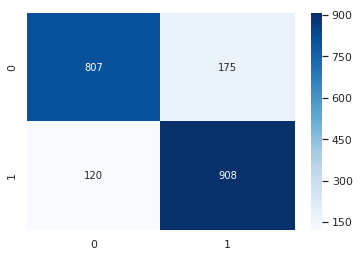

In [67]:
from sklearn.metrics import confusion_matrix
cm =confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)

## Feature importance

In [ ]:
fi = rf_feat_importance(clf, X_train)

fi.plot('cols','imp',  'barh', figsize=(20,7))

### Aldagaien original bakoitzaren garrantzia

In [58]:
from pprint import pprint
for a in sorted(list(fi.cols)):
    print(a)

Constant_Values_Zone16_tfilling
Constant_Values_Zone24_tfilling
Constant_Values_Zone9_tfilling
Flow rate_Frequency_kurtosis
Flow rate_Time_skewness
Zone10_Pressure_Frequency_kurtosis
Zone10_Pressure_Time_augmented_dickey_fuller_teststat
Zone10_Pressure_Time_percentile_75
Zone10_Pressure_Time_percentile_99
Zone10_Pressure_Time_skewness
Zone12_Pressure_Time_augmented_dickey_fuller_teststat
Zone12_Pressure_Time_median
Zone13_Pressure_Time_cid_ce
Zone13_Pressure_Time_skewness
Zone14_Pressure_Frequency_detect_peaks_0.007889546351084813
Zone14_Pressure_Time_augmented_dickey_fuller_teststat
Zone15_Pressure_Frequency_detect_peaks_0.007889546351084813
Zone15_Pressure_Frequency_kurtosis
Zone15_Pressure_Time_augmented_dickey_fuller_pvalue
Zone15_Pressure_Time_cid_ce
Zone15_Pressure_Time_percentile_99
Zone15_Pressure_Time_skewness
Zone16_Pressure_Frequency_detect_peaks_0.01183431952662722
Zone16_Pressure_Frequency_kurtosis
Zone16_Pressure_Hilbert_detect_peaks_0.007889546351084813
Zone16_Pressure_T

## Sailkapena Novelty detection erabiliz

In [187]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest( contamination=0.5, n_estimators=1000, n_jobs=-1)

isf.fit(X_train, y_train)

y_pred = isf.predict(X_test)
np.place(y_pred, y_pred==-1, [0])

/home/joanes/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/joanes/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


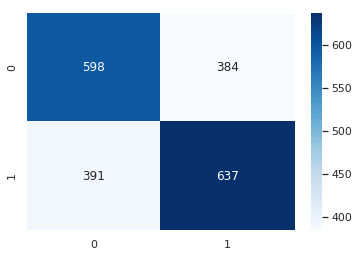

In [221]:

cm = confusion_matrix(y_test.values, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)

## Azken saiakera

### Aldagai denekin

In [8]:
clf = XGBClassifier(n_jobs=-1, max_depth=20, n_estimators=1000)
clf.fit(X_train, y_train)

evaluate(clf, X_test, y_test)

Model Performance
Accuracy = 0.8532%.
Mean Squared Error = 0.1468%.


0.8532338308457711

In [8]:
fi = rf_feat_importance(clf, X_train)

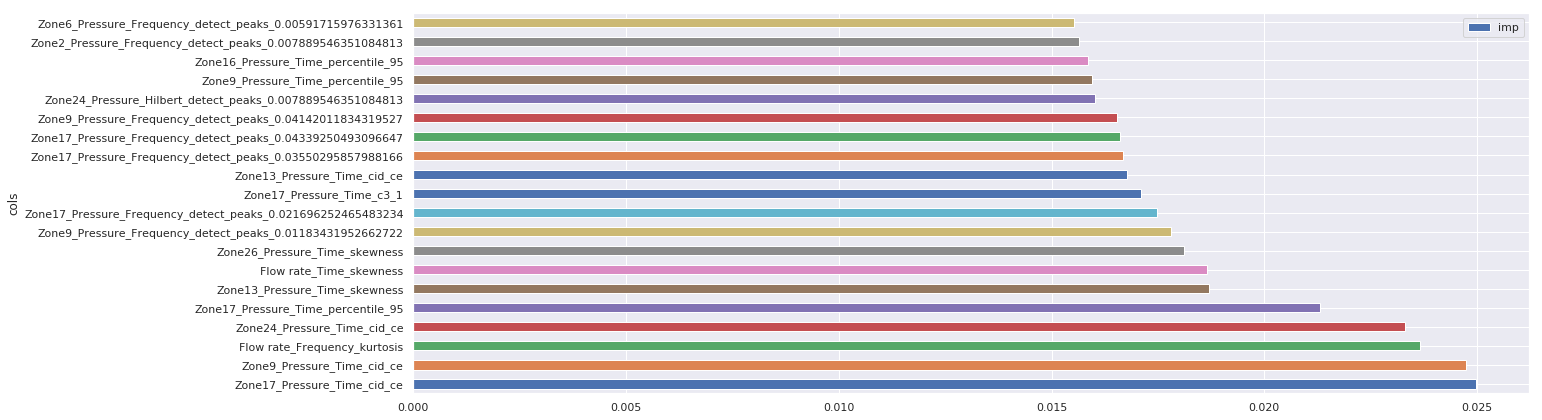

In [9]:
sns.set_style('darkgrid')
fi[:20].plot('cols','imp', 'barh', figsize=(20,7))

### Aldagaiak murriztuz

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

score_mean = []
score_std = []

for l in range(1, len(fi)):
    important_cols = features[fi[:l].cols]
    X_train, X_test = split_vals(important_cols, 8000)
    exported_pipeline =  XGBClassifier(max_depth=20,n_estimators=200, n_jobs=-1)
    scores = cross_val_score(exported_pipeline, X_train, y_train, cv=5)
    score_mean.append(scores.mean())
    score_std.append(scores.std())

Text(0, 0.5, 'Zehaztasuna')

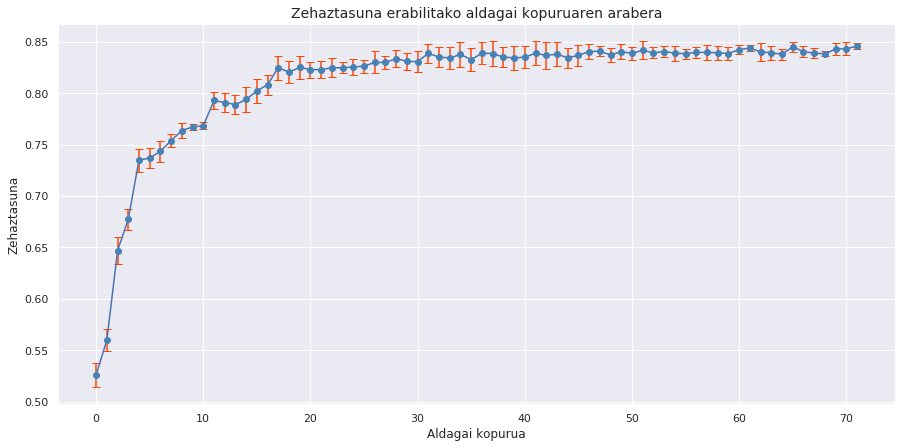

In [26]:
import seaborn; seaborn.set_style('darkgrid')

# Defining the figure and figure size
fig, ax = plt.subplots(figsize=(15, 7))

# Plotting the error bars
ax.errorbar( range(len(score_mean)), score_mean, yerr=score_std, fmt='o', ecolor='orangered',
            color='steelblue', capsize=4)
ax.plot(score_mean)
# Adding plotting parameters
ax.set_title('Zehaztasuna erabilitako aldagai kopuruaren arabera', fontsize=14)
ax.set_xlabel('Aldagai kopurua', fontsize=12)
ax.set_ylabel('Zehaztasuna', fontsize=12)


## Etorkizuneko ildoak

In [6]:
import matplotlib.pyplot as plt
raw_files = glob('/media/joanes/0BB3-1FA1/CSV_DATA/*.csv')


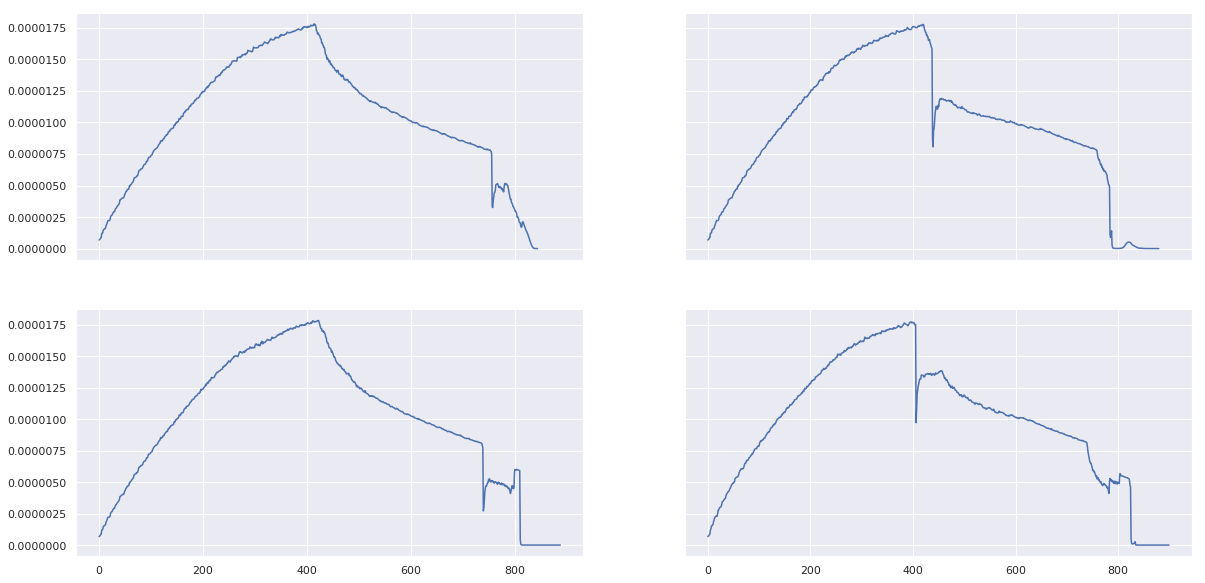

In [7]:
num_of = 2

fig, axs = plt.subplots(num_of,num_of, sharex='col', sharey='row', figsize=(20,10))
    
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        data = pd.read_csv(raw_files[num_of*i + j])
        a.plot(data['Flow rate'])

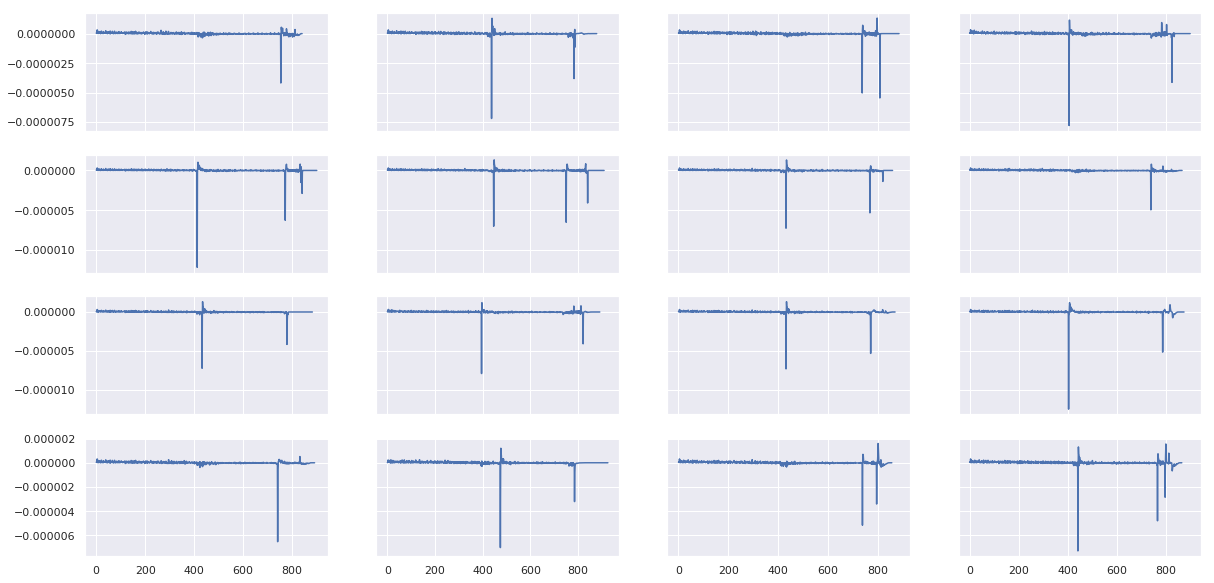

In [8]:
num_of = 4


fig, axs = plt.subplots(num_of,num_of, sharex='col', sharey='row', figsize=(20,10))
    
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        data = pd.read_csv(raw_files[num_of*i + j])
        
        a.plot(np.diff(data['Flow rate']))
    

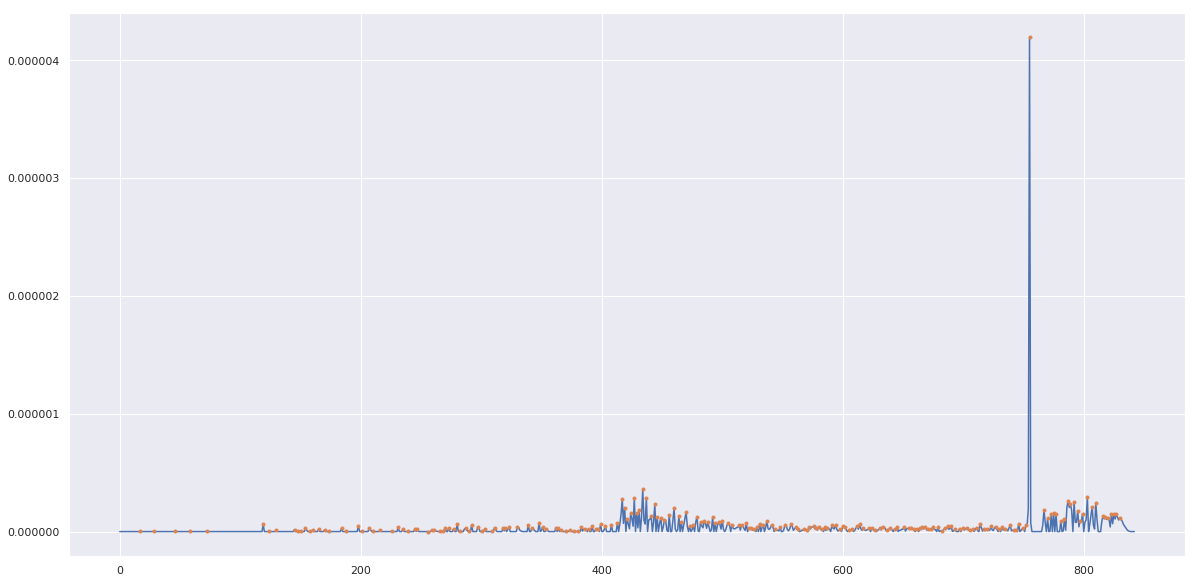

In [9]:
import peakutils
data = pd.read_csv(raw_files[0])

flow_rate_deriv = np.diff(data['Flow rate']) * -1
flow_rate = flow_rate_deriv
np.place(flow_rate, flow_rate < 0, [0])
plt.figure( figsize=(20,10))
plt.plot(flow_rate,)
indexes = peakutils.indexes(flow_rate, thres=0.)        
plt.plot(indexes, flow_rate[indexes] , marker="o", ls="", ms=3 )        

In [1]:
import peakutils
num_of = 10


fig, axs = plt.subplots(num_of,num_of, sharex='col', sharey='row', figsize=(20,10))
    
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        data = pd.read_csv(raw_files[num_of*i + j])
        flow_rate_deriv = np.diff(data['Flow rate']) * -1
        flow_rate = flow_rate_deriv[350:450]
        np.place(flow_rate, flow_rate < 0, [0])    
        indexes = peakutils.indexes(flow_rate, thres=0.5, min_dist=10) + 350
        a.plot(data['Flow rate'])
        a.axvline(indexes[0], color='gray', linestyle='--')
        flow_rate = flow_rate_deriv[700:]
        np.place(flow_rate, flow_rate < 0, [0])    
        indexes2 = peakutils.indexes(flow_rate, thres=0.05, min_dist=10) + 700
        indexes = np.hstack((indexes, indexes2))
        a.axvline(indexes2[0], color='gray', linestyle='--')
#         a.plot(indexes, data['Flow rate'][indexes] , marker="s", ls="", ms=5, color='r' )        




NameError: name 'plt' is not defined